In [1]:
import importlib

import ase.io as aio
from ase.units import Bohr
import numpy as np
import glob

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import bt_tools as bt
importlib.reload(bt)

from matplotlib import pyplot as plt

### calculate effective core charge

In [2]:
weighted_core = lambda Ne, Zs, Zp: 2*Zs/Ne + (Ne-2)/Ne*Zp

zs2 = np.array([3.217, 3.847, 4.492, 5.128])
zp2 = np.array([3.136, 3.834, 4.453, 5.100])

zs3 = np.array([4.903, 	5.642, 	6.367, 	7.068])
zp3 = np.array([4.285, 4.886, 5.482, 6.116])

zs4 = np.array([8.044, 	8.944, 	9.758, 	10.553])
zp4 = np.array([6.780, 7.449, 8.287, 9.028])

zs = [zs2, zs3, zs4]
zp = [zp2, zp3, zp4]
ne = [4, 5, 6, 7]
z_eff = []
for rs, rp in zip(zs, zp):
    zr = []
    for s, p, n in zip(rs, rp, ne):
        zr.append(weighted_core(n, s, p))
    z_eff.append(zr)
    
# z_eff = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]
# z_eff = [zp2, zp3, zp4]

In [3]:
z_eff

[[3.1765, 3.8392, 4.466, 5.108],
 [4.593999999999999, 5.1884, 5.776999999999999, 6.388],
 [7.412000000000001, 8.047, 8.777333333333333, 9.463714285714287]]

## optimize with effective core charges

In [4]:
importlib.reload(bt)

def comp_dist2(var, alpha, beta, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha+b_prime*Z1*Z2)
    dist = a/d+b#+b/d+c
    return(comp*dist)

def comp_gamma_dist2(var, alpha, beta, gamma, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2
    dist = a/d+b#/d+c
    return(comp*dist)

<ipython-input-4-8ead18c3c0d9>:11: RuntimeWarning: overflow encountered in power
  comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2


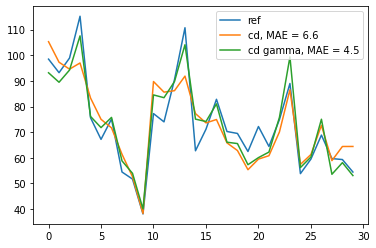

In [5]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

for e, z in zip([e2, e3, e4], z_eff):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)

b_zeff = bt.BDE_dist(energies, z_eff, distances)

b_zeff.fit(comp_dist2)
cd_mae = b_zeff.mae.copy()
bde_cd = b_zeff.bde_fitted.copy()

b_zeff.fit(comp_gamma_dist2)
cd_gamma_mae = b_zeff.mae.copy()
bde_cd_gamma = b_zeff.bde_fitted.copy()

plt.plot(b_zeff.bde, label = 'ref')
plt.plot(bde_cd, label = f'cd, MAE = {np.round(cd_mae, 1)}')
plt.plot(bde_cd_gamma, label = f'cd gamma, MAE = {np.round(cd_gamma_mae, 1)}')
plt.legend()

## optimize $Z_\text{eff}$

In [6]:
comp_gamma_dist2_flexible_zeff_lat = None

def comp_gamma_dist2_flexible_zeff(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, b_prime, a, b = args[1:7]
    Zeffs = args[7:]
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    
    Z1, Z2, d = var.T
    Z1e = np.array([Zeffs[lookup.index(int(_))] for _ in Z1])
    Z2e = np.array([Zeffs[lookup.index(int(_))] for _ in Z2])
    comp = -beta**2*(Z1e**(gamma**2)+Z2e**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    dist = a/d+b#/d+c
    
    #print(args[1:])
    return(comp*dist)

In [7]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

for e, z in zip([e2, e3, e4], z_eff):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)

nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]

# initial parameters
b_ini = bt.BDE_dist(energies, z_eff, distances)
b_ini.fit(comp_gamma_dist2)
alpha, beta, gamma, bprime, a, b = b_ini.params[0].copy()
p0 = np.array((alpha, np.sqrt(abs(beta)), np.sqrt(abs(gamma)), np.sqrt(abs(bprime)), a, b))
p0 = np.concatenate((p0, np.array(z_eff).flatten()))

# fitoptimizeoptimize
b_flexi_zeff = bt.BDE_dist(energies, nuc_charges, distances)
b_flexi_zeff.fit(comp_gamma_dist2_flexible_zeff, p0)

plt.rcParams['font.size'] = 15
plt.plot(b_flexi_zeff.bde)
plt.plot(b_flexi_zeff.bde_fitted, label = r'$Z_{\rm{eff, opt}}$, MAE = ' + str(np.round(b_flexi_zeff.mae, 2)))
plt.legend()

<ipython-input-4-8ead18c3c0d9>:11: RuntimeWarning: overflow encountered in power
  comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

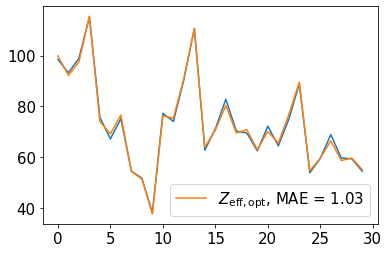

In [8]:
params = comp_gamma_dist2_flexible_zeff_lat
ebfe_flexi = comp_gamma_dist2_flexible_zeff(*(b_flexi_zeff.xdata, *params))
bde_flexi = -(ebfe_flexi+b_flexi_zeff.nbfe)

mae_flexi = np.abs(bde_flexi-b_flexi_zeff.bde).mean()

plt.rcParams['font.size'] = 15
plt.plot(b_flexi_zeff.bde)
plt.plot(bde_flexi, label = r'$Z_{\rm{eff, opt}}$, MAE = ' + str(np.round(mae_flexi, 2)))
plt.legend()

## optimize $Z_\text{eff}$ a la Guido

In [9]:
def comp_gamma_dist2_flexible_zeff2(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, b_prime, a, b = args[1:7]
    Zeffs = args[7:]
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    
    Z1, Z2, d = var.T
    Z1e = np.array([Zeffs[lookup.index(int(_))] for _ in Z1])
    Z2e = np.array([Zeffs[lookup.index(int(_))] for _ in Z2])
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    dist = a/d+b#/d+c
    
    #print(args[1:])
    return(comp*dist)

<ipython-input-4-8ead18c3c0d9>:11: RuntimeWarning: overflow encountered in power
  comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2


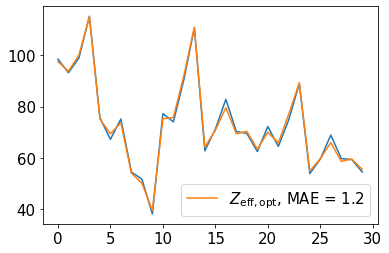

In [10]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

for e, z in zip([e2, e3, e4], z_eff):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)

nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]

# initial parameters
b_ini = bt.BDE_dist(energies, z_eff, distances)
b_ini.fit(comp_gamma_dist2)
alpha, beta, gamma, bprime, a, b = b_ini.params[0].copy()
p0 = np.array((alpha, np.sqrt(abs(beta)), np.sqrt(abs(gamma)), np.sqrt(abs(bprime)), a, b))
p0 = np.concatenate((p0, np.array(z_eff).flatten()))

# fitoptimizeoptimize
b_flexi_zeff = bt.BDE_dist(energies, nuc_charges, distances)
b_flexi_zeff.fit(comp_gamma_dist2_flexible_zeff2, p0)

plt.rcParams['font.size'] = 15
plt.plot(b_flexi_zeff.bde)
plt.plot(b_flexi_zeff.bde_fitted, label = r'$Z_{\rm{eff, opt}}$, MAE = ' + str(np.round(b_flexi_zeff.mae, 2)))
plt.legend()

In [11]:
p0

array([-6.10130279e+01,  1.34578408e+00,  1.20470154e+00,  4.02548489e+00,
       -4.14345132e-02,  2.33107298e+00,  3.17650000e+00,  3.83920000e+00,
        4.46600000e+00,  5.10800000e+00,  4.59400000e+00,  5.18840000e+00,
        5.77700000e+00,  6.38800000e+00,  7.41200000e+00,  8.04700000e+00,
        8.77733333e+00,  9.46371429e+00])

In [15]:
b_flexi_zeff.params[0]

array([ 4.07237528e+02,  4.84367911e-03,  1.24060301e+00,  7.87627869e+00,
       -9.17409997e+00,  3.97030599e+00,  1.39721863e+01,  1.67386895e+01,
        1.93759544e+01,  2.20949693e+01,  1.16119366e+01,  1.30335497e+01,
        1.44544111e+01,  1.59309072e+01,  1.72848363e+01,  1.87281630e+01,
        2.03960198e+01,  2.19642806e+01])

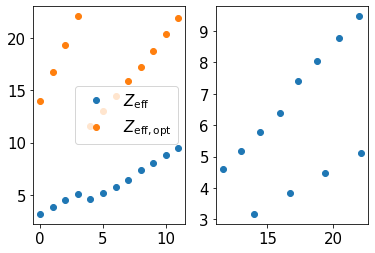

In [12]:
z_eff_optimized = b_flexi_zeff.params[0][6:]
z_efff = np.array(z_eff).flatten()
nuc_chargesf = np.array(nuc_charges).flatten()

fig, ax = plt.subplots(1,2)
# ax[0].plot(nuc_chargesf, 'o', label = 'Z')

ax[0].plot(z_efff, 'o', label = r'$Z_{\rm{eff}}$')
ax[0].plot(z_eff_optimized, 'o', label = r'$Z_{\rm{eff, opt}}$')
ax[1].plot(z_eff_optimized, z_efff, 'o')

ax[0].legend()

## fixed Zeff only in b'

In [13]:
def comp_gamma_dist2_flexible_zeff3(*args):

    Z1, Z2, d, Z1e, Z2e = args[0].T
    alpha, beta, gamma, b_prime, a, b = args[1:]
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    dist = a/d+b#/d+c
    
    #print(args[1:])
    return(comp*dist)

In [48]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

for e, z in zip([e2, e3, e4], z_eff):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)

nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]

# initial parameters
b_ini = bt.BDE_dist(energies, z_eff, distances)
b_ini.fit(comp_gamma_dist2)
alpha, beta, gamma, bprime, a, b = b_ini.params[0].copy()
p0 = np.array((alpha, np.sqrt(abs(beta)), np.sqrt(abs(gamma)), np.sqrt(abs(bprime)), a, b))

# initial parameters
b_zeff3 = bt.BDE_dist(energies, nuc_charges, distances)

# add Z_eff variable
z_eff_data = []
for z in z_eff:
    for i in range(len(z)):
        for j in range(i, len(z)):
            z_eff_data.append([z[i], z[j]])
z_eff_data = np.array(z_eff_data)

b_zeff3.xdata = np.concatenate((b_ini.xdata, z_eff_data), axis=1)

b_zeff3.fit(comp_gamma_dist2_flexible_zeff3, p0)

<ipython-input-46-8ead18c3c0d9>:11: RuntimeWarning: overflow encountered in power
  comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2


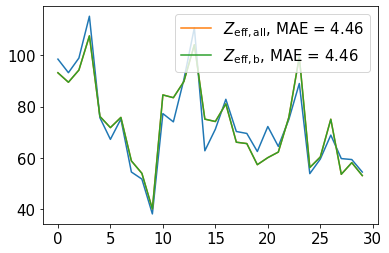

In [62]:
plt.rcParams['font.size'] = 15
plt.plot(b_zeff3.bde)
plt.plot(b_ini.bde_fitted, label = r'$Z_{\rm{eff, all}}$, MAE = ' + str(np.round(b_ini.mae, 2)))

plt.plot(b_zeff3.bde_fitted, label = r'$Z_{\rm{eff, b}}$, MAE = ' + str(np.round(b_zeff3.mae, 2)))
plt.legend()

In [53]:
b_zeff3.params[0]

array([-29.88184975,   1.26748243,   1.45130605,  11.34040107,
        -0.0846019 ,   4.7596156 ])

In [54]:
b_ini.params[0]

array([-6.10130279e+01,  1.81113479e+00,  1.45130580e+00,  1.62045286e+01,
       -4.14345132e-02,  2.33107298e+00])

In [56]:
np.abs(b_ini.bde_fitted-b_zeff3.bde_fitted).mean()

4.571839990603621e-05

In [ ]:
plt.plot(b2.bde)
plt.plot(b2.bde_fitted/100)

In [ ]:
p0[6:]

In [ ]:
b.xdata[:,2]

In [ ]:
b = bt.BDE_dist(energies, nuc_charges, distances)
xd2 = b.xdata[:10].copy()
xd3 = b.xdata[40:50].copy()
xd4 = b.xdata[80:].copy()
b.xdata = xdata = np.concatenate((xd2, xd3, xd4), axis = 0)

b.fit(comp_gamma_dist2)


z_i = []
z_j = []

for z in [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]:
    for i in range(4):
        
        for j in range(i, 4):
            z_i.append(z[i])
            z_j.append(z[j])
b.xdata[:,0] = z_i
b.xdata[:,1] = z_j
alpha, beta, gamma, bprime, a, bp = b.params[0]
prefix = np.array((alpha, np.sqrt(abs(beta)), np.sqrt(abs(gamma)), np.sqrt(abs(bprime)), a, bp))
p0 = np.concatenate((prefix,np.array(z_eff).flatten()))
b.fit(comp_gamma_dist2_flexible_zeff, p0)


In [ ]:
3.1295663072497493, 3.7916066250891007, 4.420174281025148, 5.066213799617203, 4.55022756654616, 5.147345117460224, 5.7424579052713645, 6.359301847358291, 7.393705208597591, 8.034710012356197, 8.774410041073597, 9.469070944311039

In [ ]:
args = (49.25133105892532, 1.0280124769188075, 1.1883677921301086, 11.419005390666927, -15.06356150603029, -1.1362304178839835, 2.7396865604667586, 3.2681554845384313, 3.772782598034162, 4.293313677822285, 4.565594205684395, 5.129663090661089, 5.693289823386943, 6.278528359706928, 7.627517948186812, 8.257668556849111, 8.985125317168567, 9.669564954616824)
np.abs(comp_gamma_dist2_flexible_zeff(b.xdata, *comp_gamma_dist2_flexible_zeff_lat) - b.ebfe).mean(), comp_gamma_dist2_flexible_zeff_lat

In [ ]:
plt.scatter(np.array(z_eff).flatten(), comp_gamma_dist2_flexible_zeff_lat[6:])
plt.plot((3,10), (3,10))

In [ ]:
plt.plot(-(comp_gamma_dist2_flexible_zeff(b.xdata, *comp_gamma_dist2_flexible_zeff_lat) + b.nbfe), label="relaxed zeff")
plt.plot(-(comp_gamma_dist2(np.concatenate((xd2, xd3, xd4), axis = 0), alpha, beta, gamma, bprime, a, bp) + b.nbfe), label="literature zeff")
plt.plot(b.bde, label="truth")
plt.legend()

### fit

In [ ]:
b.fit(comp_gamma_dist2_flexible_zeff)
# b.fit(comp_gamma_nobprime_dist2)


print(b.params[0])

el1 = ['C', 'N', 'O', 'F']
el2 = ['Si', 'P', 'S', 'Cl']
el3 = ['Ge', 'As', 'Se', 'Br']
comps = []
for el in [el1, el2, el3]:
    for i in range(len(el)):
        for j in range(i, len(el)):
            comps.append(f'{el[i]}{el[j]}')

plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(comps, b.bde, '-o', label = 'ref')
plt.plot(b.bde_fitted, '-o', label = f'pred MAE = {np.round(b.mae,1)}')
plt.ylabel('BDE (kcal/mol)')
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = [6,6]
fig,ax = plt.subplots(1,1)
ax.plot(b.bde_fitted, b.bde, 'o')

ax.set_xlim([np.amin([b.bde_fitted, b.bde])-1, np.amax([b.bde_fitted, b.bde])+1])
ax.set_ylim([np.amin([b.bde_fitted, b.bde])-1, np.amax([b.bde_fitted, b.bde])+1])

ax.set_aspect('equal', adjustable='box')

In [ ]:
b.xdata

In [ ]:
b.mae

In [ ]:
b.params[0]

### dont subtract Z1*Z2

In [ ]:
b.nbfe[:] = 0
b.ebfe = b.bfe

### random numbers for Z

In [ ]:
dZ = (np.amax(z_eff)-np.amin(z_eff))
Z_random = np.random.rand(2, 30)*dZ + np.amin(z_eff)

b.xdata[:,0] = Z_random[0]
b.xdata[:,1] = Z_random[1]

### exact distance instead of average per row

In [ ]:
def key2(x):
    pattern_list = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key3(x):
    pattern_list = ['SiSi', 'SiP','SiS','SiCl','PP','PS','PCl','SS','SCl','ClCl',]
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key4(x):
    pattern_list = ['[GeH3][GeH3]', '[GeH3][AsH2]', '[GeH3][SeH]', '[GeH3]Br', '[AsH2][AsH2]', '[AsH2][SeH]', '[AsH2]Br', '[SeH][SeH]', '[SeH]Br', 'BrBr']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)

dist_exact2 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single/*_opt.xyz', key2)
dist_exact3 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/diatomics_single/*_opt.xyz', key3)
dist_exact4 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/diatomics_single/*_opt.xyz', key4)
dist_exact = np.concatenate((dist_exact2, dist_exact3, dist_exact4))

b.xdata[:,2] = dist_exact/Bohr